# Quantum enhanced support vector machine

Authors: *Alexandre Dauphin, Patrick Huembeli, Gorka Munoz* 

In this notebook, we will explore a quantum algorithm developped to enhance a machine learning (ML) algorithm. In particular, we will study the Quantum enhanced support vector machine, introduced by the scientific staff of IBM in Ref.[1](https://arxiv.org/pdf/1804.11326.pdf).

## Brief overview of machine learning

Machine learning algorithms are mainly divided in two categories: supervised and unsupervised algorithms. 

<img src="pictures/supervised_learning.png" width=600><img src="pictures/unsupervised_learning.png" width=600>

In the case of **supervised learning**, the training set is given with labels. For example, in the MNIST dataset, the training set are hanwritten numbers and the labels are the numbers. The goal of supervised algorithm is to learn to predict these labels and to be able to generalize to unlabelled data of the same kind. After the training on MNIST, the algorithm should be able predict that an image of a 5 is actually labelled by a 5. There many examples of supersvised learning such as support vector machine, random forest, deep neural networks, etc.

In the case of **unsupervised learning**, the training set is given without labels. The goal of the algorithm is to find some structure in the data. One example of such algorithms is the k-means clustering. There, the user specifies the number of clusters he wants to find in the data and the algorithm finds automatically the different clusters. Another example is the T-SNE algotrithm, widely used for data visualisation. This algorithm takes data in a high-dimensional space and tries to find some structure in the data, that can be visualized by the user in 2D or 3D. As an example, we show here the application of the t-SNE algorithm on the MNIST dataset. Even without labels, the different numbers separate nicley in different clusters.

We will now focus on a specific supervised learning algorithm, the suppert vector machine. But, let us first introduce the data set we want to classify

## Breast Cancer dataset

We want to classfify the [Breast Cancer Wisconsin (Diagnostic) Data Set ](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). The dataset consists in 569 training examples, with each 32 attributes such as the perimeter, the texture, the area, etc. The diagnosis of these data can be malginant or benign. 

For the sake of simplicity, which will be particularly relevant for the quantum enhanced version of the algorithm, we do a dimensional reduction of our data from 32 attributes to 2, with the help of a [principal component analysis](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales) (PCA). Such unsupervised algorithm finds the principal axes of the data with a singular value decomposition.

In [1]:
import numpy as np
from dataset import breast_cancer
from sklearn.datasets.samples_generator import make_blobs
from qiskit.aqua.utils import split_dataset_to_data_and_labels 
from sklearn import svm
from utils import svm_utils 
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

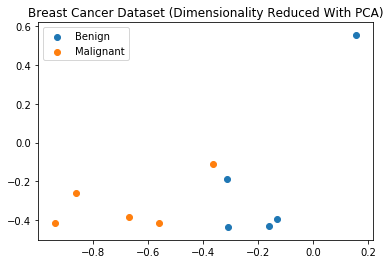

In [3]:
n = 2 # number of principal components kept
training_dataset_size = 5
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, _ = split_dataset_to_data_and_labels(training_input)
data_test, _ = split_dataset_to_data_and_labels(test_input)

#print(training_input)
#print(data_train[1])

## Linear Support vector machine

We first emphasize that there two types of data that can be classified by these algorithms: linearly separable datasets and non linearly separable datasets. Our dataset is clearly not linearly separable. We show two examples in the different classes here below.

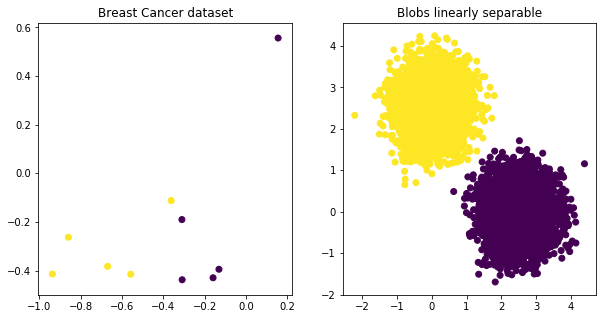

In [4]:
# We use the function of scikit learn to generate linearly separable blobs
centers = [(2.5,0),(0,2.5)]
x, y = make_blobs(n_samples=10000, centers=centers, n_features=2,random_state=0,cluster_std=0.5)


fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(data_train[0][:,0],data_train[0][:,1],c=data_train[1])
ax[0].set_title('Breast Cancer dataset');

ax[1].scatter(x[:,0],x[:,1],c=y)
ax[1].set_title('Blobs linearly separable');



Let us first focus on the linearly separable dataset. We would first like to separate linearly the data set. However, there are many ways separating linearly this dataset,as one can see in the image below. Ideally, the separating line should be chosen such that it can generalize properly. 

<img src="pictures/linearly_separable.png" width=600>

### Linear Support vector machine: Hard margins and soft margins

<img src="pictures/linear_svm_hardcore.png" width=600>

The support vector machine algorithm tries to find the parameters $w$ and $b$ such that:

- the data with labels $y=1$ satisfy $w\,x+b>1$
- the data with labels $y=-1$ satisfy $w\,x+b<1$.

The optimization problem therefore consists in maximizing the distance between the two hyperplanes $\frac{2}{\vert \vert w \vert \vert}$ (or minimizing $\vert \vert w \vert \vert^2$) given the constraints $y_i (w\,x+b)>1$. This problem corresponds to the optimization of a quadratic problem with linear constraints 

$\min \limits_{w,b}\vert \vert w\vert \vert^2 \text{ such that } y_i (w \, x_i+b)\geq 1, i=1...N$

and has therefore a unique extremum. The latter can be found with a gradient-descent technique.

In some of the problems, one would prefer to have a control on the margins by giving a weight to every point of the dataset, which would be an hyper parameter. This can done by considering the following problem

$\min \limits_{w,b,\xi_i>0}\vert \vert w\vert \vert^2+C\sum_{i=1}^{N}\xi_i \text{ such that } y_i (w x_i+b)\geq 1-\xi_i, i=1...N$

See that we are comparing here two contradictory positions: If we increase margin, we will end up getting a high misclassfication rate on the other hand if we decrease a margin, we will end up getting a lower misclassification rate. The value of C allows one to control the size of the margins. For $C=\infty$, we recover the hard margin case. 

Combining the inequalities $\xi\geq 0$ and $y_i (w x_i+b)\geq 1-\xi_i$, the minization problem can be rewritten as

$\min \limits_{w,b,\xi_i>0}\vert \vert w\vert \vert^2+C\sum_{i=1}^{N}\max(0,1-y_i (w x_i+b))$

The second term of this inequality is the so called Hinge Loss and the SVM problem can be seen as a minization of the Hinge Loss with a $L_2$ regularization of the weigths. We finally notice that problem has still a unique minimum.

### Support vector machine and dual problem

One can show that the optimization problem of the SVM is equivalent to the minization its dual formulation. For example, in the case of the soft margins, the dual problem takes the form

$\max \limits_{\{\alpha_i\}}\sum_i-\frac{1}{2}\sum_{j,k}\alpha_j\alpha_k y_j y_k (x_j^Tx_k) \text{ with the constraints } 0 \leq \alpha_i \leq C \text{ and } \sum_i \alpha_i y_i=0$

One of the advantages of this formulation is that oit only involves the scalar products $ x_j^T x_k$. This is a crucial point when we will go to kernel methods. 

## Support vector machine with Kernel

<img src="pictures/feature_space.png" width=600>

As we have already seen, the data are not always linearly separable. A simple trick to be able to still use a linear classifier are the kernel methods, as sketched in the Figure above. For example, this one-dimensional dataset is not linearly separable. However, when embedding them in the two-dimensional space with the map $\Phi: x \rightarrow (x,x^2)$. The datas become again linearly separable.

In the dual formulation, one only has to compute the scalar product $ x_j^T x_k$, which after the embedding takes the form $ \Phi(x_j^T) \Phi(x_k)$. What we have done is to redefine the concept of scalar product to a kernel, $k(x_j, x_k) = \Phi(x_j^T) \Phi(x_k)$.

Using this as a basis, people have introduced what is called the *kernel trick*: instead of defining a non-linear mapping as we did above, we can define a non-linear kernel as a functions of the scalar product of the data: $k(x_j, x_k)=f(x_j\cdot x_k)$. $f$ can be you favourite non-linear function! An example are the gaussian kernels, where the data are embedded in a high dimensional space and mapped to gaussians, where the scalar product can be computed analitcally. 

# Hands-on session on support vector machine

### Linear SVM

Before going to quantum case, we will implement the both the linear and kernel SVM algorihms for the  breast cancer dataset. We first have a look at our data set

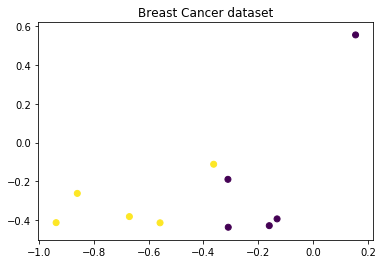

In [5]:
plt.scatter(data_train[0][:,0],data_train[0][:,1],c=data_train[1])
plt.title('Breast Cancer dataset');

We then define a linear SVM classifier and train it on the data set.

In [6]:
model= svm.LinearSVC()
model.fit(data_train[0], data_train[1])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

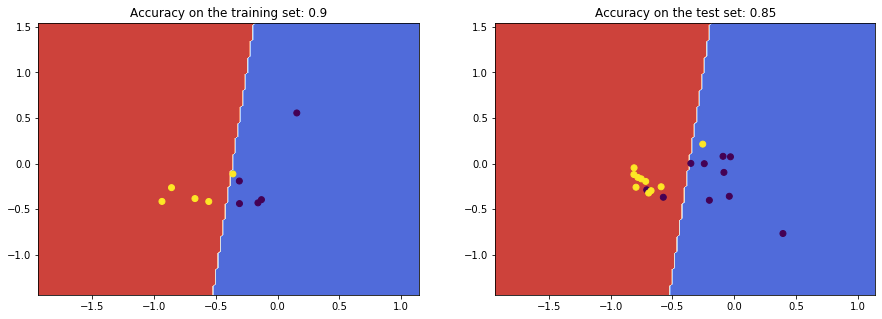

In [7]:
accuracy_train = model.score(data_train[0], data_train[1])
accuracy_test = model.score(data_test[0], data_test[1])


X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(data_train[0][:,0], data_train[0][:,1], c=data_train[1])
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(data_test[0][:,0], data_test[0][:,1], c=data_test[1])
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

The background indicates the decision function for the SVM algorithm. 


**Exercise:** 
- Apply the same linear SVM to the blobs to see how good the algorithm is in this case.
- Play with the value $C$ in this case to see if the accuracy of the prediction changes. Remember, $C=\infty$ is the hard margin case.

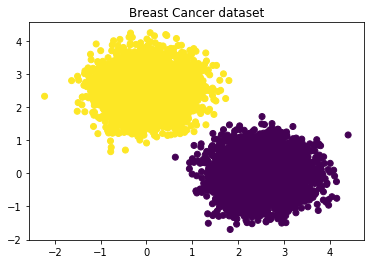

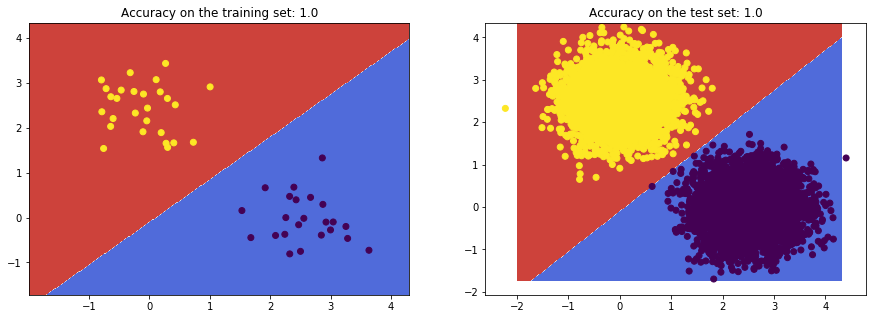

In [8]:
plt.scatter(x[:,0],x[:,1],c=y)
plt.title('Breast Cancer dataset');
model= svm.LinearSVC(C = 20000)

model.fit(x[0:50], y[0:50])
accuracy_train = model.score(x[0:50], y[0:50])
accuracy_test = model.score(x[51:], y[51:])


X0, X1 = x[51:99,0],x[51:99,1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(x[0:50,0], x[0:50,1], c=y[0:50])
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(x[51:,0], x[51:,1], c=y[51:])
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

Como vemos ahora el porcentaje de acierto es de 1 ya que efectivamente teníamos un distribución separable linealmente

### SVM with non-linear kernel

We now implement a SVM with gaussian kernel

In [9]:
clf = svm.SVC(gamma = 'scale')
clf.fit(data_train[0], data_train[1]);

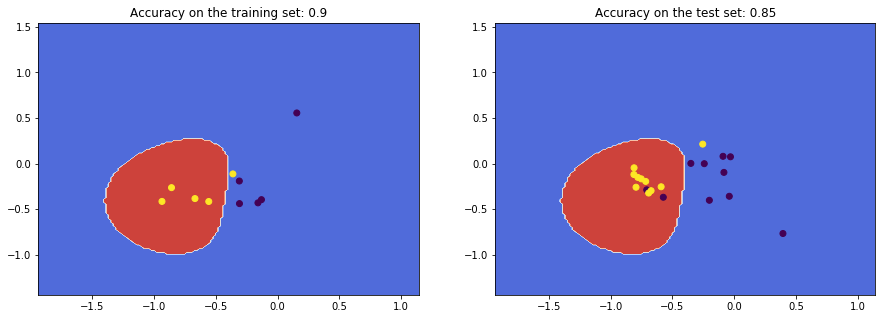

In [10]:
accuracy_train = clf.score(data_train[0], data_train[1])
accuracy_test = clf.score(data_test[0], data_test[1])


X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(data_train[0][:,0], data_train[0][:,1], c=data_train[1])
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(data_test[0][:,0], data_test[0][:,1], c=data_test[1])
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

### Creating your custom kernel

The package `scikit-learn` allows us to create our own custom kernel. This is, a function whose input are two numpy arrays of length constainining $N$ and $M$ vectors of arbitrary length $L$ (all vectors must have the same length. In the previous example, $L=2$) and whose output is a matrix $N\times M$. To find the support vector with your custom kernel, you can then use

`clf = svm.SVC(kernel=my_custom_kernel)`

**Exercise:** Create your own custom kernel and use it to classify both the blobs and the breast cancer dataset.

(50, 2)
++++++++++++++++++++++++
(50, 2)
(50, 50)
!!!!!!!!!!!!!!!!
(50, 2)
++++++++++++++++++++++++
(50, 2)
(50, 50)
!!!!!!!!!!!!!!!!
(9949, 2)
++++++++++++++++++++++++
(50, 2)
(9949, 50)
!!!!!!!!!!!!!!!!
(96064, 2)
++++++++++++++++++++++++
(50, 2)
(96064, 50)
!!!!!!!!!!!!!!!!


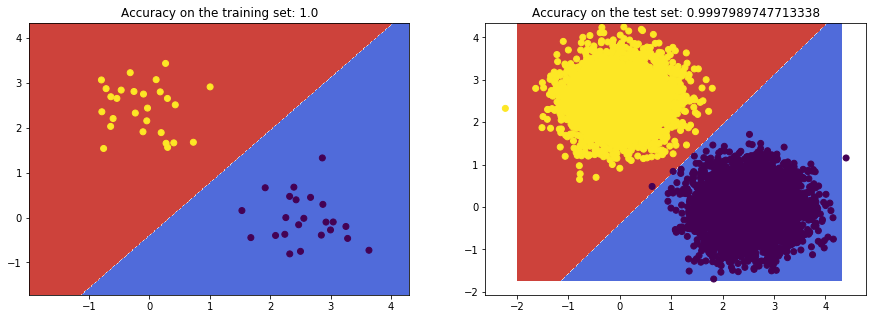

In [11]:
def my_kernel (X,Y) :
    print(X.shape)
    print("++++++++++++++++++++++++")
    print(Y.shape)
    ind = np.dot(X,Y.T)
    print (ind.shape)
    print("!!!!!!!!!!!!!!!!")
    return np.dot(X,Y.T)

def my_kernel3(X,Y):
    sigma = 0.5
    ind = np.power(np.dot(X,Y.T),2)
    print(ind.shape)
    return ind

model = svm.SVC(kernel=my_kernel)

model.fit(x[0:50], y[0:50])
accuracy_train = model.score(x[0:50], y[0:50])
accuracy_test = model.score(x[51:], y[51:])


X0, X1 = x[51:99,0],x[51:99,1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(x[0:50,0], x[0:50,1], c=y[0:50])
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(x[51:,0], x[51:,1], c=y[51:])
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));



(10, 10)
(10, 10)
(20, 10)
(23250, 10)


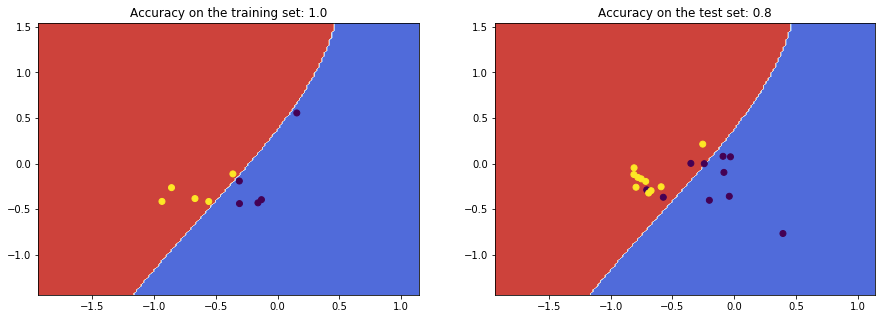

In [12]:
def my_kernel4(X,Y):
    sigma = 0.5
    ind = np.power(np.dot(X,Y.T),2)
    print(ind.shape)
    return ind
def my_kernel5(X,Y):
    ind = np.exp(np.dot(X,Y.T))
    print(ind.shape)
    return ind
# Ahora vamos a intentar plantear el que no tiene separación lineal con otro tipo de Kernel
clf = svm.SVC(C=2000,kernel=my_kernel5)
clf.fit(data_train[0], data_train[1]);
accuracy_train = clf.score(data_train[0], data_train[1])
accuracy_test = clf.score(data_test[0], data_test[1])


X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[0].scatter(data_train[0][:,0], data_train[0][:,1], c=data_train[1])
ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
ax[1].scatter(data_test[0][:,0], data_test[0][:,1], c=data_test[1])
ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

## Quantum Classification

Remember what is the idea of a classical SVM. We have a set of points that are in either one group or another and we want to find a line that separates these two groups. This line can be linear, but it can also be much more complex, which can be achieved by the use of Kernels.

**So what will we need in the case of a quantum computer?**

- 1st we will have to translate the classical data point $\vec{x}$ into a quantum datapoint $\vert \Phi{(\vec{x})} \rangle$. This can be achieved by a circuit $\mathcal{U}_{\Phi(\vec{x})} \vert 0 \rangle $. Where $\Phi()$ could be any classical function applied on the classical data $\vec{x}$.

- 2nd we need a parameterized quantum circuit $W( \theta )$ that processes the data in a way that in the end we...

- 3rd can apply a measurement that returns a classical value $-1$ or $1$ for each classical input $\vec{x}$ that indentifies the label of the classical data.

**The most general ansatz**

Following these steps we can define an ansatz for this kind of problem which is $W(\theta) \mathcal{U}_{\Phi}(\vec{x}) \vert 0 \rangle$.

These kind of ansatz are called quantum variational circuits.

### Quantum SVM

The first introduction of the QSVM was made in Ref. [[2]](https://arxiv.org/pdf/1307.0471.pdf). There, they took advantage of the computational speed up of matrix inversion in quantum computers to propose a Quantum implementation of the classical algorithm. We will not focus on this implementation, but we will use it as an excuse to study the **Quantum Fourier Transforms** and the **HHL algorithm**, two subroutines used in such implementation. This two will be reviewed in different notebooks.

Now lets focus in the IBM implementation. In the case of a quantum SVM we will only used the quantum feature maps $\mathcal{U}_{\Phi(\vec{x})}$ to translate the classical data into quantum states and build the Kernel of the SVM out of these quantum states. After calculating the Kernel matrix on the quantum computer we can train the Quantum SVM the same way as the classical SVM.

**Defining the Quantum Kernel**

The idea of the quantum kernel is exactly the same as in the classical case. We take the inner product $K(\vec{x}, \vec{z}) = \vert \langle \Phi (\vec{x}) \vert \Phi(\vec{z}) \rangle \vert^2 = \langle 0^n \vert \mathcal{U}_{\Phi(\vec{x})}^{t} \mathcal{U}_{\Phi(\vec{z})} \vert 0^n \rangle$, but now with the quantum feature maps $\mathcal{U}_{\Phi(\vec{x})}$. The idea is that if we choose a quantum feature maps that is not easy to simulate with a classical computer we might obtain a quantum advantage.

Side note: _There is no proof yet that the QSVM brings a quantum advantage, but the argument the authors of [1](https://arxiv.org/pdf/1804.11326.pdf) make, is that there is for sure no advantage if we use feature maps that are easy to simulate classically, because then we would not need a quantum computer to construct the Kernel._

**Feature map**

For the feature maps we use the ansatz $\mathcal{U}_{\Phi(x)} = U_{\Phi(x)} \otimes H^{\otimes n}$, where $U_{\Phi(x)} = \exp \left( i \sum_{S \in n} \phi_S(x) \prod_{i \in S} Z_i \right)$, which simplifies a lot when we (like in [1](https://arxiv.org/pdf/1804.11326.pdf)) only consider $S \leq 2$ interactions, which means we only let two qubits interact at a time.
For $S \leq 2$ the product $\prod_{i \in S}$ only leads to interactions $Z_i Z_j$ and non interacting terms $Z_i$. And the sum $\sum_{S \in n}$ over all these terms that are possible with $n$ qubits.

Finally we define the classical functions $\phi_i(\vec{x}) = x_i$ and $\phi_{i,j}(\vec{x}) = (\pi - x_i)( \pi- x_j)$.

If we write this ansatz for 2 qubits and $S \leq 2$ we see how it simplifies:

$$U_{\Phi(x)} = \exp \left(i \left(x_1 Z_1 + x_2 Z_2 + (\pi - x_1)( \pi- x_2) Z_1 Z_2 \right) \right)$$

We won't get into details to much here, why we would take this ansatz. It is simply an ansatz that is simple enough an leads to good results.

Finally we can define a depth of these circuits. Depth 2 means we repeat this ansatz two times. Which means our feature map becomes $U_{\Phi(x)} \otimes H^{\otimes n} \otimes U_{\Phi(x)} \otimes H^{\otimes n}$

**Measuring the Quantum Kernel**

Finally we need to extract the information about the quantum kernel again from the quantum circuit to feed it into the classical SVM algorithm. This is actual a non-trivial task, because we want to measure the overlap of two states $K(\vec{x}, \vec{z}) = \vert \langle \Phi (\vec{x}) \vert \Phi(\vec{z}) \rangle \vert^2$ but there is a smart way to estimate this overlap, in [1](https://arxiv.org/pdf/1804.11326.pdf) they used this circuit for that estimation. 

<img src="pictures/Kernel_estimate.png" width=600>

Which simply uses the fact that **if** $\mathcal{U}_{\Phi(x)} = \mathcal{U}_{\Phi(z)}$ the whole unitary would simplify to $\mathbb{1}$ and the input should be equal to the output.
If we now measure the output, the frequency of the measurement string $0^n$ gives you an estimate of the overlap $\vert \langle \Phi (\vec{x}) \vert \Phi(\vec{z}) \rangle \vert^2$. (Because initially all qubits were $\vert 0 \rangle$)

### Build circuit for feature map

Qiskit Aqua provides a pre-built function that can construct the quantum circuit for $\mathcal{U}_{\Phi(x)}$. The Second Order Expansion refers to the number of interacting qubits which we called $S$ before. Since $S \leq 2$ we have terms with maximally two interacting qubits $Z_i Z_j$ (not for example $Z_i Z_j Z_k$), therefore Second Order.

The function `SecondOrderExpansion` has the arguments `feature_dimension`, which is the dimension of the input data $\vec{x}$ and at the same time also the number of qubits. `depth` is the number of repetitions of the feature map.

In [19]:
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

feature_map = SecondOrderExpansion(feature_dimension=2, 
                                   depth=1)

#### Print the feature map circuit

To print the feature map circuit we define an arbitrary vector `x` that we want to encode and construct the circuit for this datapoint.

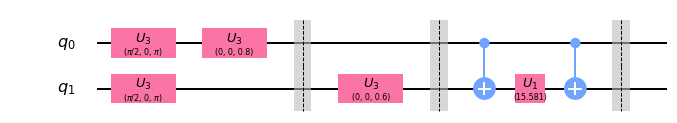

In [20]:
x = np.array([0.4, 0.3])
feature_map.construct_circuit(x).draw(output='mpl')

You might wonder now why there are no $Z_i$ and $Z_i Z_j$ matrices. This is simply because Qiskit does not provide these gates. We have to tranlate them into the gate set that Qiskit provides, which are manly 1-qubit rotations (here `U3`) and CNOTs. Qiskit does this work for us. It translates our feature map directly to gates that can be run on their qunatum computer. This is called compiling.

### QSVM Algorithm

Qiskit aqua also provides a pre-defined function to train the whole QSVM. Where we only have to provide the feature map, a training and a test set and Qiskit will do all the work for us.

Apart from finding the quantum Kernel the QSVM algorithm does only classical optimization. In the end there is no difference to the classical SVM, except that the Kernels are coming from a quantum distribution.

QSVM will minimize the loss 
$$L(W) = \sum_i \alpha_i - \frac{1}{2}\sum_{i,j} y_i y_j \alpha_i \alpha_j K(\vec{x}_i, \vec{x}_j)$$
via optimizing the parameters $\vec{\alpha}$.

After training we can predict a label $y'$ of a data instance $\vec{s}$ with $y' = \text{sign}\left( \sum_i y_i \alpha_i K(\vec{x}_i, \vec{s}) \right)$.

In [21]:
from qiskit.aqua.algorithms import QSVM

qsvm = QSVM(feature_map, training_input, test_input)

#### Run QSVM

Finally we will have to define where we would like to run this algorithm. For now we will run it on a local QASM Simulator. But the algorithm could also be sent to the IBMQ an be evaluated on a real quantum computer.

We will have to define the `shots`, which are the number of measurements that we will take for each qubit. And for better reproducability we also set here the random seeds `seed_simulator` and `see_transpiler`.

In [ ]:
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit import BasicAer

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1)

result = qsvm.run(quantum_instance)

### Analyze output

`results` is a dictionary that contains elements like the kernel matrix, the label predictions and also the classical weights of the QSVM.

Let's have a quick look at them:

#### The kernel matrix for the training

Since the training set contains 40 elements, the kernel matrix has dimension 40x40

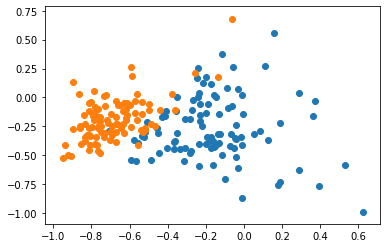

size training set: 200


TypeError: 'Result' object is not subscriptable

In [25]:
plt.scatter(training_input['Benign'][:,0], training_input['Benign'][:,1])
plt.scatter(training_input['Malignant'][:,0], training_input['Malignant'][:,1])
plt.show()
length_data = len(training_input['Benign']) + len(training_input['Malignant'])
print("size training set: {}".format(length_data))
print("Matrix dimension: {}".format(result['kernel_matrix_training'].shape))

The success ratio shows how accurate the QSVM predicts the labels

In [ ]:
print("testing success ratio: ", result['testing_accuracy'])

In [ ]:
test_set = np.concatenate((test_input['Benign'], test_input['Malignant']))
y_test = qsvm.predict(test_set, quantum_instance)

And here we plot the results. The first plot shows the label predictions of the QSVM and the second plot shows the test labels.

In [ ]:
plt.scatter(test_set[:, 0], test_set[:,1], c=y_test)
plt.show()

plt.scatter(test_input['Benign'][:,0], test_input['Benign'][:,1])
plt.scatter(test_input['Malignant'][:,0], test_input['Malignant'][:,1])
plt.show()

**Exercise:**
- You can acces the circuit for the kernel product between two vectors $x$ and $z$ using the code below. Use it to create a custom kernel and evaluate it with the SVM solver of `scikit-learn` that we used above. Remember that the frequency of measuring the string $0^n$ gives you an estimate of the overlap $\vert \langle \Phi (\vec{x}) \vert \Phi(\vec{z}) \rangle \vert^2$.

In [22]:
from qiskit import *
from qiskit.visualization import plot_histogram 
x = np.array([0.4, 0.3])
z = np.array([0.9, 0.7])
circuit = qsvm.construct_circuit(x, z)
# Medir, sacar el valor del número de veces que hemos obtenido 0 y con eso tenemos el custom kernel. 
circuit.measure(0,0)
circuit.measure(1,1)
circuito = circuit
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuito,simulator,shots = 10000)
result = job.result()
counts = result.get_counts(circuito)
#plot_histogram(counts)
print(counts['00']/10000)



0.3287


# References

[1] Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209–212 (2019).

[2] Rebentrost, P., Mohseni, M. & Lloyd, S. *Quantum support vector machine for big data classification*, Physical
review letters 113, 130503 (2014).

[3] Lectures notes on Machine learning, Andrew Zisserman  (2015)

[4] Kristin P. Bennett and Colin Campbell, Support Vector Machines: Hype or Hallelujah?, SIGKDD Explorations 2, 1 (2000)

In [23]:
#n = 2 # number of principal components kept
#training_dataset_size = 5
#testing_dataset_size = 10

#sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

#data_train, _ = split_dataset_to_data_and_labels(training_input)
#data_test, _ = split_dataset_to_data_and_labels(test_input)


# Con eso utilizar skitkit con el kernel custom cuántico
def q_circuit(xi,xj):
    kernresult = float(0)
    try :
        circuit = qsvm.construct_circuit(xi,xj)
        circuit.measure(0,0)
        circuit.measure(1,1)
        circuito = circuit
        simulator = Aer.get_backend('qasm_simulator')
        job = execute(circuito,simulator,shots = 10000)
        result = job.result()
        counts = result.get_counts(circuito)
        kernresult = counts['00']/10000
    except:
        pass
    return float(kernresult)
# Ahora creemos el custom kernel
def my_kernel_q(X,Y):
    MAT = np.zeros((X.shape[0],X.shape[0]))
    for i in range (0,X.shape[0]):
        for j in range (0,Y.shape[0]):
            MAT[i][j] = q_circuit(X[i], Y[j])
    return MAT



In [24]:
q_circuit(data_train[0][0],data_train[0][2])
my_kernel_q(data_train[0],data_train[0])

array([[1.000e+00, 1.416e-01, 3.006e-01, 2.040e-01, 1.402e-01, 1.736e-01,
        2.411e-01, 1.678e-01, 3.690e-01, 2.222e-01],
       [1.398e-01, 1.000e+00, 8.566e-01, 9.528e-01, 7.009e-01, 4.228e-01,
        3.290e-02, 4.830e-02, 7.405e-01, 4.200e-03],
       [3.164e-01, 8.495e-01, 1.000e+00, 9.232e-01, 4.064e-01, 6.044e-01,
        9.600e-03, 1.926e-01, 9.817e-01, 1.049e-01],
       [1.996e-01, 9.511e-01, 9.270e-01, 1.000e+00, 4.926e-01, 4.515e-01,
        0.000e+00, 1.250e-01, 8.526e-01, 5.630e-02],
       [1.439e-01, 7.059e-01, 4.082e-01, 4.903e-01, 1.000e+00, 1.891e-01,
        4.568e-01, 6.780e-02, 3.034e-01, 1.901e-01],
       [1.679e-01, 4.254e-01, 6.059e-01, 4.507e-01, 1.933e-01, 1.000e+00,
        4.550e-02, 3.998e-01, 6.438e-01, 2.198e-01],
       [2.435e-01, 3.230e-02, 7.600e-03, 2.000e-04, 4.543e-01, 4.560e-02,
        1.000e+00, 7.146e-01, 3.030e-02, 9.160e-01],
       [1.615e-01, 5.060e-02, 1.939e-01, 1.223e-01, 6.850e-02, 3.946e-01,
        7.148e-01, 1.000e+00, 2.823e-

In [25]:
# Ahora vamos a aplicar este custom kernel como arriba
clf = svm.SVC(C=2000,kernel=my_kernel_q)
clf.fit(data_train[0], data_train[1])
accuracy_train = clf.score(data_train[0], data_train[1])
#accuracy_test = clf.score(data_test[0], data_test[1])


#X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
#xx, yy = svm_utils.make_meshgrid(X0, X1)
#Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)

#fig,ax=plt.subplots(1,2,figsize=(15,5))
#ax[0].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
#ax[0].scatter(data_train[0][:,0], data_train[0][:,1], c=data_train[1])
#ax[0].set_title('Accuracy on the training set: '+str(accuracy_train));

#ax[1].contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
#ax[1].scatter(data_test[0][:,0], data_test[0][:,1], c=data_test[1])
#ax[1].set_title('Accuracy on the test set: '+str(accuracy_test));

In [ ]:
X0, X1 = data_train[0][:, 0], data_train[0][:, 1]
xx, yy = svm_utils.make_meshgrid(X0, X1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)